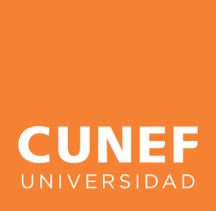

Realizado por:

***Sergio Ranz Casado***  
***Marcos Medina Cogolludo***

---

**3.0.5. Modelo LightGBM**
---
[`LightGBM`](https://medium.com/@pushkarmandot/https-medium-com-pushkarmandot-what-is-lightgbm-how-to-implement-it-how-to-fine-tune-the-parameters-60347819b7fc) es un algoritmo de refuerzo (o también de potenciación) de gradientes (gradient boosting) basado en modelos de árboles de decisión. Puede ser utilizado para la categorización, clasificación y muchas otras tareas de aprendizaje automático, en las que es necesario maximizar o minimizar una función objetivo mediante la técnica de gradient boosting, que consiste en combinar clasificadores sencillos, como por ejemplo árboles de decisión de profundidad limitada.

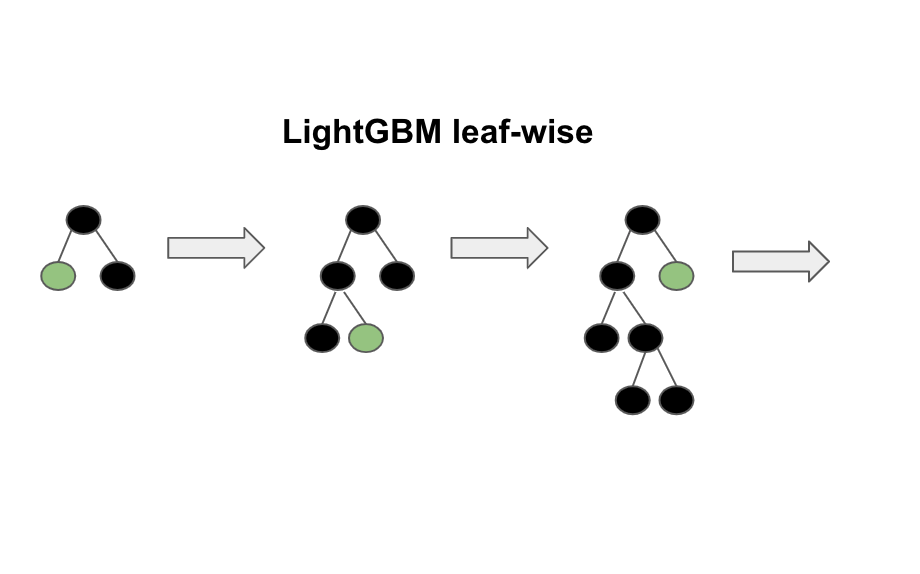


**METODOS DE CLASIFICACIÓN**
---

Como ya hemos comentado en notebooks anteriores. El principal problema que nos encontramos en este dataset es el desbalanceo de datos. La gran desproporcionalidad que existe entre los accidentes de trafico mortales de los que no son mortales es de 2% a 98%. Si bien, es cierto que hemos actuado frente a este desbalanceo mediante una `técnica de muestreo aleatorio`en el notebook 
[2.0.3.Preprocesing.](http://localhost:8888/notebooks/Desktop/CUNEF/Practica%20Machine%20Learning/project_template/notebooks/2.0.3.%20Preprocesing.%20SPLIT%2C%20NA%2C%20OUTLIER.%20.ipynb) 

Sin embargo, nos seguimos encontrado con este problema en la muestra de test seleccionada. Esto afectará a nuestras métricas, en nuestro caso, no representarán la precisión ni el recall adecuado del modelo.

Sabiendo el problema al que nos enfrentamos y teniendo como objetivo la predicción de la mortalidad en un accidente de tráfico. (Problema de clasificación), enumeramos a continuación las métricas que vamos a utilizar: 

- `Precisión:` Se define como la división de los verdaderos positivos (TP) de entre todos los positivos predichos (TP + FP).En nuestro caso en particular, será este dato el que este desequilibrado, ya que hay una desproporcionalidad de la muestra de muertes y no muertes. 

$$\frac{\textrm{TP}}{\textrm{TP+FP}}$$


- `Recall:` Se define como todos los ejemplos predichos que pertenecen a una clase (TP) de entre todos los positivos predichos (TP + FN). 

$$\frac{\textrm{TP}}{\textrm{TP+FN}}$$

- [`Accuracy`](https://machinelearningmastery.com/failure-of-accuracy-for-imbalanced-class-distributions/): Es una metrica que resume el rendimiento de un modelo de clasificación con el número de predicciones correctas dividido por el número total de predicciones. Debido a que la predicción no es una métrica fiable, esta métrica tampoco lo será. 

$$\frac{\textrm{TP+TN}}{\textrm{TP+TN+FP+FN}}$$

- [`Matriz de confusión:`](https://medium.com/analytics-vidhya/accuracy-on-imbalanced-datasets-and-why-you-need-confusion-matrix-937613bf89bf) La métrica mas simple y al mismo tiempo la más efectiva para mirar el desempeño de los modelos en casos de dataset imbalanceados. Nos muestra la relacción que existe entre positivos acertados (TP), positivos fallados (FN), negativos acertados(TN), y negativos fallados (FP). 


- [`F1-Score:`](https://www.iartificial.net/precision-recall-f1-accuracy-en-clasificacion/) La F-Score combina las dos métricas de precisión y recall dentro de un mismo valor, añadiendo un parámetro `Beta`, que aplica un peso mayor a la precisión (Beta < 1) o un peso mayor al recall (Beta > 1). En nuestro caso, aplicaremos una F-1, ya que el peso lo aplicaremos en el modelo.

$$2 \times\frac{\textrm{Precision} \times \textrm{Recall}}{\textrm{Precision} + \textrm{Recall}}$$
    
   
- [`La curva ROC:`](https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-imbalanced-classification/) Resume el rendimiento del modelo en la clase binaria positiva. Es una herramienta de diagnóstico popular para clasificadores en problemas de predicción binaria balanceados y desequilibrados por igual porque no está sesgada hacia la clase mayoritaria o minoritaria.


- [`Precision-Recall AUC:`](https://www.davidsbatista.net/blog/2018/08/19/NLP_Metrics/) Representa la precisión y el recall para diferentes umbrales de probabilidad. Es una tecnica muy efectiva para dataset desequilibrados debido a su enfoque en la clase minoritaria, es decir, en la mortalidad. 


- [`Cumulative Gain Curve`](https://towardsdatascience.com/meaningful-metrics-cumulative-gains-and-lyft-charts-7aac02fc5c14#:~:text=The%20cumulative%20gains%20curve%20is,target%20according%20to%20the%20model.) Evalua el rendimiento del modelo comparando los resultado con la selección aleatoria.


- [`Lift Curve`](https://towardsdatascience.com/meaningful-metrics-cumulative-gains-and-lyft-charts-7aac02fc5c14#:~:text=The%20cumulative%20gains%20curve%20is,target%20according%20to%20the%20model.) Mide la cantidad de ganancias que tiene nuestro modelo aplicandolo con respecto a la selección aleatorio.  Nos indica cuanto vale la pena implementar ese modelo. 


#### Importo Librerias:

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import pyarrow.csv as pv
import pyarrow.parquet as pq
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import pyplot
from sklearn import preprocessing
import pandas as pd
import pyarrow.csv as pv
import pyarrow.parquet as pq
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, \
                            silhouette_score, recall_score, precision_score, make_scorer, \
                            roc_auc_score, f1_score, precision_recall_curve
from sklearn.metrics import accuracy_score, roc_auc_score, \
                            classification_report, confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn import tree
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import fbeta_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from lightgbm import LGBMClassifier
import lightgbm as lgb
import time
import pickle
import scikitplot as skplt

---

#### Importamos Funciones:

In [3]:
def classify_metrics(modelo, x_test, y_test, predict): 
    
    '''Imprimimos el reporte de clasificación:  '''
    
    print("Classification Report")
    print(classification_report(y_test, predict))
    
    '''Imprimimos el Accuracy: '''
    print("Accuracy:", metrics.accuracy_score(y_test, predict))
    
    '''Imprimimos el F1-score'''
    print("F1-Score:", metrics.f1_score(y_test, predict))
    
    print("---")
    
    '''Matriz de confusión: '''
    titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(modelo, x_test, y_test,
                                     display_labels=["mortal", "no mortal"],
                                     cmap=plt.cm.Blues,
                                     normalize=normalize)
        disp.ax_.set_title(title)

        print(title)
        print(disp.confusion_matrix)

    plt.show()
    
    yhat = modelo.predict_proba(x_test)
    pos_pred = yhat[:,1]
    
    # calculate roc curves
    fpr, tpr, thresholds = roc_curve(y_test, pos_pred)
    # plot the roc curve for the model
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='Random Forest')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    # show the plot
    plt.show()

    
    # calculate the g-mean for each threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    
    # locate the index of the largest g-mean
    ix = np.argmax(gmeans)
    print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
    
    '''Dibujando la curva ROC: '''
    print("CURVA ROC con THRESHOLD:")
    # plot the roc curve for the model
    plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
    plt.plot(fpr, tpr, marker='.', label='Modelo')
    plt.scatter(fpr[ix], tpr[ix], s=100, marker='o', color='black', label='Best')
    # axis labels
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    # show the plot
    plt.show()
    
    '''Calculando el area AUC: '''
    print("AREA AUC: ")
    # calculate roc auc
    roc_auc = roc_auc_score(y_test, pos_pred)
    print('ROC AUC %.3f' % roc_auc)
    
    '''Calculamos la curva pr: '''
    # calculate pr-curve
    precision, recall, thresholds = precision_recall_curve(y_test, pos_pred)
    print("PRECISSION/RECALL CURVE: ")
    # plot the roc curve for the model
    no_skill = len(y_test[y_test==1]) / len(y_test)
    plt.plot([0,1], [no_skill,no_skill], linestyle='--', label='No Skill')
    plt.plot(recall, precision, marker='.', label='model')
    # axis labels
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    # show the plot
    plt.show()
    
    '''Cumulative Gain Curve: '''
    skplt.metrics.plot_cumulative_gain(y_test, yhat)
    plt.show()
    
    '''Lift Curve:'''
    skplt.metrics.plot_lift_curve(y_test, yhat)
    plt.show()

#### Importamos Train y Test

In [4]:
train = pd.read_parquet('../data/trainselect1.parquet')
test = pd.read_parquet('../data/testselect1.parquet')

In [5]:
x_train = train.drop('c_sev',axis=1)
x_test = test.drop('c_sev',axis=1)
y_train = train['c_sev']
y_test = test['c_sev']

---

#### Modelo LightGBM

Primero vamos a usar ciertos parametros que creemos que se pueden ajustar mejor al modelo, posteriormente los probaremos con un GridSearch:

In [6]:
%%time
lgbm = LGBMClassifier(objective='binary', scale_pos_weight=0.6)
start = time.time()
model5 = lgbm.fit(x_train, y_train)
end = time.time()
y_pred_lgbm = model5.predict(x_test)
print(y_pred_lgbm)
print("tiempo de ejecución del fit: ", end - start)

[1 1 0 ... 1 1 0]
tiempo de ejecución del fit:  0.2169947624206543
Wall time: 687 ms


#### Metricas:

Classification Report
              precision    recall  f1-score   support

           0       0.04      0.69      0.08      8960
           1       0.99      0.68      0.81    453620

    accuracy                           0.68    462580
   macro avg       0.52      0.68      0.44    462580
weighted avg       0.97      0.68      0.79    462580

Accuracy: 0.6805914652600631
F1-Score: 0.8068813359055999
---
Confusion matrix, without normalization
[[  6162   2798]
 [144954 308666]]
Normalized confusion matrix
[[0.68772321 0.31227679]
 [0.3195494  0.6804506 ]]


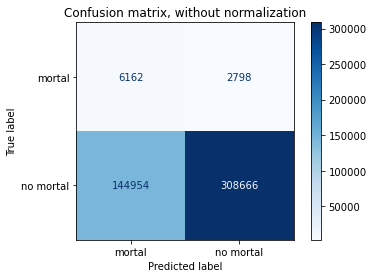

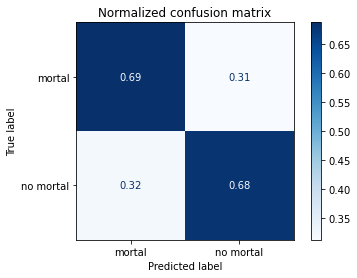

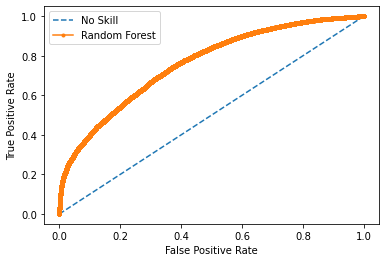

Best Threshold=0.492527, G-Mean=0.685
CURVA ROC con THRESHOLD:


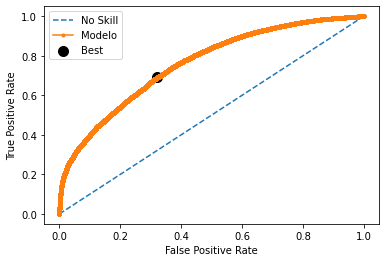

AREA AUC: 
ROC AUC 0.761
PRECISSION/RECALL CURVE: 


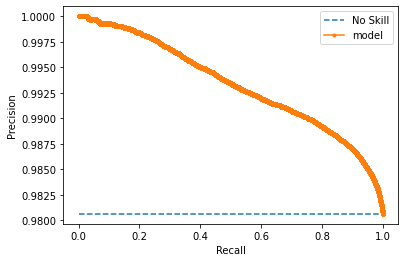

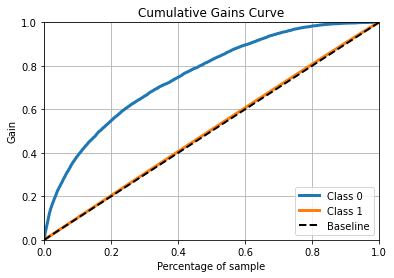

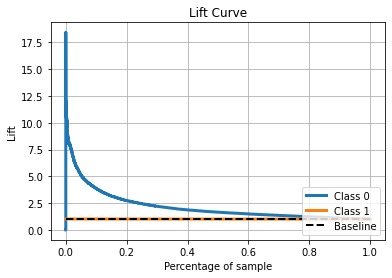

In [7]:
classify_metrics(model5, x_test, y_test,y_pred_lgbm)

#### Queremos determinar la importancia de las variables sobre la variable objetivo: 

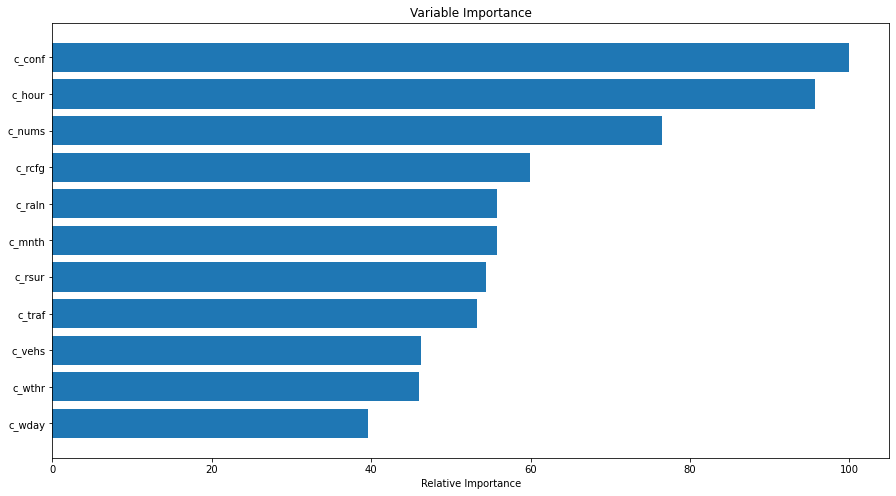

In [8]:
feature_importance = model5.feature_importances_
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
# plt.subplot(1, 2, 2)
plt.figure(figsize=(15, 8))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, x_train.keys()[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

---

#### LIGHTGBM CON VALIDACIÓN CRUZADA Y SELECCIÓN DE PARAMETROS:

La [`validación cruzada o cross-validation`](https://es.wikipedia.org/wiki/Validaci%C3%B3n_cruzada) es una técnica utilizada para evaluar los resultados de un análisis estadístico y garantizar que son independientes de la partición entre datos de entrenamiento y prueba. Consiste en repetir y calcular la media aritmética obtenida de las medidas de evaluación sobre diferentes particiones.

En este dataset nos volvemos a topar con el problema de desbalanceo del dataset sobre todo en la parte del test. Para ello, el cross validation tiene que adaptarse a esta desproporción. Utilizaremos el 'RepeatedStratifiedKFold' que estratifica la muestra de train manteniendo la proporción de muertes y no muertes.

Los parametros mas importantes de [`LightGBM`](https://neptune.ai/blog/lightgbm-parameters-guide#:~:text=Feature%20fraction%20or%20sub_feature%20deals,features%20before%20training%20each%20tree) son los siguientes: 

- `num_leaves:` Este parámetro se usa para establecer el número de hojas que componen cada árbol. La conexión teórica entre num_leaves y max_depth es: num_leaves = 2 ^ (max_depth). Sin embargo, si se utiliza LightGBM, esta estimación es incorrecta: utiliza leaf_wise en lugar de depth_wise para dividir los nodos de hoja. Por lo tanto, num_leaves debe establecerse en un valor menor que 2 ^ (max_depth). De lo contrario, puede causar sobreajuste. No existe una relación directa entre los parámetros num_leave y max_depth de LightGBM. Por lo tanto, no debemos vincular los dos juntos.


- `min_data_in_leaf:` También es un parámetro muy importante para el sobreajuste. Establecerlo en un valor particularmente pequeño puede causar un sobreajuste, por lo que debemos configurarlo en consecuencia. Por lo tanto, para grandes conjuntos de datos, debemos establecer su valor en cientos a miles.


- `max_depth:` Especifica la profundidad máxima de cada árbol o el número máximo de capas que puede crecer.


- `Learning_rate`: Es la tasa de aprendizaje del algoritmo. Si esta es demasiado alta, el algoritmo tenderá al sobreajuste, mientras que, si es muy baja, el algoritmo se estancará y no llegará a su objetivo. Por defecto es 0.1. 


ajustes de [`LightGBM`](https://lightgbm.readthedocs.io/en/latest/pythonapi/lightgbm.LGBMClassifier.html)


- `num_leaves:` Establecerlo demasiado grande hace que el árbol sea más profundo y preciso, pero esto conduce a un sobreajuste. Por lo tanto, no es bueno establecer su valor demasiado alto. 


- `max_bin:` El efecto de establecer este valor más alto es similar al efecto de crecimiento de num_leaves, y hará que nuestro proceso de entrenamiento se vuelva lento. 

Asimismo, utilizaremos el [`gridsearch`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html) para encontrar los mejores parametros, esta función tambien tiene parametros que son dignos de mención: 

- `verbose:` Pondremos =1 para que nos de el tiempo de ejecución del codigo. 


- `n_jobs:` Pondremos =-1 para que la maquina utilice todos los procesadores de la cpu. 

---

In [9]:
%%time
parameters = {
    'learning_rate': np.arange(0.08,0.10,0.01),
    'boosting_type': ["gbdt", "dart"],
    'max_depth': np.arange(1,4,1),
    'num_leaves': np.arange(2,8,2),

}

lgbm = LGBMClassifier(objective='binary', alpha=1, scale_pos_weight=0.66)

'''Asignamos la validación cruzada: '''
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=12345)

'''Asignamos el GridSearch: '''
start=time.time()
gs = GridSearchCV(lgbm, parameters, verbose=1, n_jobs=-1, cv=cv, scoring='roc_auc')
model5cv = gs.fit(x_train, y_train)
end=time.time()
y_pred_lgbm_cv = model5cv.predict(x_test)

'''imprimimos los parametros: '''
print(model5cv.best_params_)
print(model5cv.best_score_)
print("tiempo de ejecución del fit:", end - start)

Fitting 30 folds for each of 54 candidates, totalling 1620 fits
{'boosting_type': 'gbdt', 'learning_rate': 0.09999999999999999, 'max_depth': 3, 'num_leaves': 6}
0.7691603441687729
tiempo de ejecución del fit: 138.1611397266388
Wall time: 2min 18s


#### Lo guardamos en [`Pickle`](https://machinelearningmastery.com/save-load-machine-learning-models-python-scikit-learn/): 

In [10]:
filename = '../models/model5cv.sav'
pickle.dump(model5cv, open(filename, 'wb'))

#### Load Pickle: 

In [11]:
%%time
filename = '../models/model5cv.sav'
model5cv = pickle.load(open(filename, 'rb'))
y_pred_lgbm_cv = model5cv.predict(x_test)
print(y_pred_lgbm_cv)

[1 1 0 ... 1 1 0]
Wall time: 311 ms


#### Metricas:

Classification Report
              precision    recall  f1-score   support

           0       0.04      0.71      0.07      8960
           1       0.99      0.66      0.79    453620

    accuracy                           0.66    462580
   macro avg       0.52      0.68      0.43    462580
weighted avg       0.97      0.66      0.78    462580

Accuracy: 0.6582428985256604
F1-Score: 0.7904455137127027
---
Confusion matrix, without normalization
[[  6330   2630]
 [155460 298160]]
Normalized confusion matrix
[[0.70647321 0.29352679]
 [0.34270976 0.65729024]]


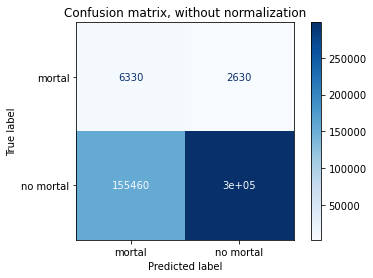

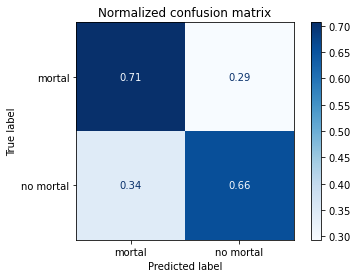

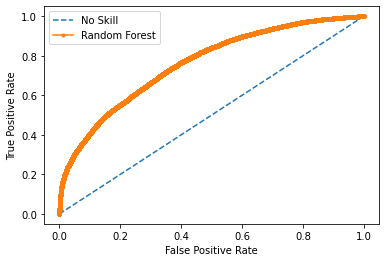

Best Threshold=0.479937, G-Mean=0.684
CURVA ROC con THRESHOLD:


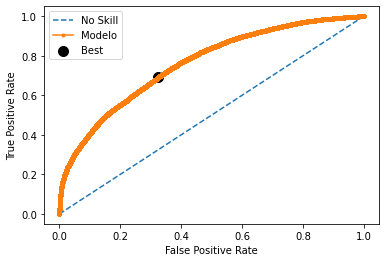

AREA AUC: 
ROC AUC 0.762
PRECISSION/RECALL CURVE: 


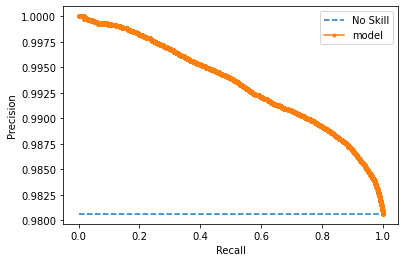

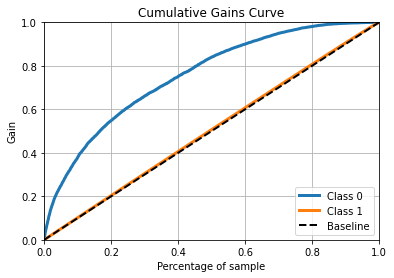

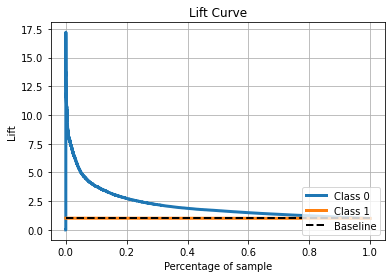

In [12]:
classify_metrics(model5cv, x_test, y_test, y_pred_lgbm_cv)

---

#### COMENTARIOS:

El tiempo del LightBoost como era de esperar es mas rápido que del [`XGBoost`](http://localhost:8888/notebooks/Desktop/CUNEF/Practica%20Machine%20Learning/project_template/notebooks/3.0.4.%20Modelos.%20XGBOOST.ipynb), por lo que, entendemos que a la hora de poner en producción nuestro modelo, estos tendrán preferencia sobre el XGBoost.

En cuanto a sus métricas, comenzamos hablando del primer modelo (sin parámetros), este modelo presenta en la matriz de confusión una igualdad entre las predicciones de mortalidad 69% frente a la predicciones de no mortalidad 68%. Lo que implica que activaremos únicamente un 1% mas de lo correspondiente, lo que, a mi criterio puede ser poco ya que no estamos contando con el margen de fallo del modelo. 
La curva ROC presenta una superficie de 76.1% muy semejante a las del XGBoost, la PR curve parece que en ciertos tramos va mas a favor del recall que de la precisión, especialmente entre el 0,4 y 0,6. 
Por último, la curva de ganancia nos muestra que nuestro modelo, dentro del 20% de los casos con mas probabilidad de accidentes mortales, contienen mas del 55% de los casos de mortalidad en accidentes de tráfico, lo que implica un gran porcentaje. La curva Lift nos muestra que nuestro modelo es 2.5 - 3 veces mejor que aplicar un modelo aleatorio para el 20% de los casos con mas probabilidad de accidentes.


Respecto al modelo parametrizado, vemos como la matriz de confusión nos presenta unos aciertos de la  matriz de confusión del 71%  de mortalidad frente a los 66% de los no mortalidad. Lo que nos deja un 5% de importe mas activado, cifra que parece bastante aceptable para nuestro caso, pues, como hemos comentado anteriormente, hay que tener en cuenta el principio de prudencia y eso implica contar con un cierto margen de error del modelo. Un 5% creo que es suficiente. 
La curva ROC arroja una superficie del 76,2% muy semejante a la anterior, sin embargo, en este caso es logico que haya subido ya que uno de los parametros escogidos en el gridsearh ha sido `scoring="roc_auc"`que se encarga de maximizar dicha curva. 
La curva Pr es muy semejante al anterior modelo, aunque parece que el tramo a favor del recall se ha mitigado. Las curvas de ganancias y lift no han cambiado con respecto al modelo sin parametrizar. La conclusión sigue siendo la misma.


**Hemos decidido tomar este último modelo como modelo definitivo para la predicción de los accidentes de tráfico mortales y la correspondiente activación de la firma aseguradora del dinero correspondiente a principio del periodo contable.
Hemos guardado el modelo en pickle, el cual lo trataremos en el siguiente notebook de [interpretabilidad.](http://localhost:8888/notebooks/Desktop/CUNEF/Practica%20Machine%20Learning/project_template/notebooks/3.0.8.%20INTERPRETABILIDAD.%20.ipynb)**

---

#### De cara a interpretabilidad, elaboramos el modelo con los parámetros obtenidos en el gridsearch...

In [13]:
%%time
lgbm = LGBMClassifier(objective='binary',alpha=1, scale_pos_weight=0.6, 
                     boosting_type="gbdt", learning_rate=0.1, max_depth=3,
                      num_leaves=6)
start = time.time()
model5_def = lgbm.fit(x_train, y_train)
end = time.time()
y_pred_lgbm = model5_def.predict(x_test)
print(y_pred_lgbm)
print("tiempo de ejecución del fit: ", end - start)

[1 0 0 ... 1 1 0]
tiempo de ejecución del fit:  0.10799860954284668
Wall time: 391 ms


#### Lo guardamos en pickle...

In [14]:
filename = '../models/model5def.sav'
pickle.dump(model5_def, open(filename, 'wb'))

---

#### ENLACES DE INTERÉS:

[`LightGBM`](https://programmerclick.com/article/1448249738/)

[`LightGBM UOC`](http://datascience.recursos.uoc.edu/es/lightgbm/)

[`Más parametros LightGBM`](https://programmerclick.com/article/145090017/)

[`Difference between scale_weight & scale_pos_weight`](https://datascience.stackexchange.com/questions/54043/differences-between-class-weight-and-scale-pos-weight-in-lightgbm)

[`Sentiment Analysis with Imbalanced Dataset in LightGBM`](https://stackoverflow.com/questions/47187750/sentiment-analysis-with-imbalanced-dataset-in-lightgbm)

---